In [6]:
import os
import pandas as pd
import numpy as np
import random
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pandas import Series
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
random.seed(0)

In [12]:
etf_list = ['SPY','IVV','VTI','VOO','QQQ','VEA','EFA','IEFA','VWO','AGG','IJH','IEMG','IWM','IJR','VTV','IWF','IWD','VUG','BND','LQD','XLF','VNQ','VIG','EEM','GLD','VB','BSV','VO','TIP','VEU','IVW','DIA','XLK','VYM','VGT','VCSH','MDY','IWB','VCIT','XLV','IWR','XLE','DVY','USMV','EWJ','VGK','PFF','SCHF','SDY','RSP','XLY','ITOT','IVE','SCHX','HYG','SHV','VBR','EMB','SHY','VV','SCHB','XLI','BIV','VT','MBB','BNDX','IWS','VXUS','FLOT','IWO','IXUS','MINT','SCZ','PYZ','MXI','IYM','IXP','RXI','VCR','RHS','VDC','PXI','PXE','IEO','RYF','IYG','KIE','FBT','PTH','IHI','ITA','VIS','ICF','REZ','RWR','PSJ','IGV','RYU','IDU','VPU']
data = pd.read_csv('stats_100_etfs.csv')
data

date    open    high     low   close     volume ticker  \
0       2015-01-29  200.38  202.30  198.68  201.99  173585424    SPY   
1       2015-01-30  200.57  202.17  199.13  199.45  197729724    SPY   
2       2015-02-02  200.05  202.03  197.86  201.92  163106969    SPY   
3       2015-02-03  203.00  204.85  202.55  204.84  124212881    SPY   
4       2015-02-04  203.92  205.38  203.51  204.06  134306728    SPY   
...            ...     ...     ...     ...     ...        ...    ...   
123895  2019-12-23  143.28  143.29  141.21  141.55     173189    VPU   
123896  2019-12-24  141.59  141.78  141.04  141.62      52726    VPU   
123897  2019-12-26  141.85  142.05  141.37  141.86      68987    VPU   
123898  2019-12-27  142.01  142.27  141.71  142.25     107721    VPU   
123899  2019-12-30  141.92  142.34  141.61  142.25     148696    VPU   

        Clf_Target  1day_change  2day_change  3day_change  4day_change  \
0              0.0        -1.85         0.75         3.46         2.98   
1              1.0         2.54         0.69         3.29         6.00   
2              1.0        -2.47         0.07        -1.78         0.82   
3              0.0        -2.92        -5.39        -2.85        -4.70   
4              1.0         0.78        -2.14        -4.61        -2.07   
...            ...          ...          ...          ...          ...   
123895         1.0         1.49         0.41         0.53        -0.23   
123896         1.0        -0.07         1.42         0.34         0.46   
123897         1.0        -0.24        -0.31         1.18         0.10   
123898         0.5        -0.39        -0.63        -0.70         0.79   
123899         1.0        -0.00        -0.39        -0.63        -0.70   

        5day_change       ewma7      ewma50     ewma200      MACD        RSI  
0              4.11  202.607510  202.813380  202.823244 -0.051351  49.664254  
1              5.52  201.812154  202.546072  202.608549 -0.250332  44.689405  
2              3.53  201.839268  202.498240  202.566959 -0.243913  49.940725  
3             -2.10  202.592637  202.670737  202.697663 -0.048698  55.339046  
4             -3.92  202.960644  202.769663  202.772444  0.051507  53.673969  
...             ...         ...         ...         ...       ...        ...  
123895        -0.62  141.546517  140.143844  135.478711  0.616715  56.661665  
123896        -0.30  141.564887  140.201733  135.539819  0.617189  57.012288  
123897         0.22  141.638666  140.266763  135.602706  0.629673  58.259176  
123898        -0.29  141.791499  140.344537  135.668849  0.663388  60.275586  
123899         0.79  141.906124  140.419261  135.734333  0.682244  60.275586  

[123900 rows x 18 columns]

In [13]:
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] )
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] )
    d = d.drop(d.index[:(period-1)])
    rs = Series.ewm(u, com=period-1, adjust=False).mean() / \
    Series.ewm(d, com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

In [14]:
# PREPROCESSING AND DATA SELECTION
def produce_data():
    indices = [961, 573, 1102, 1091, 228, 1070, 513, 1106, 6, 530]
    starter = [data[i] for i in indices]
    starter = [i.set_index('Date') for i in starter]
    for i in range(0,len(starter)):
        starter[i]['RSI'] = RSI(starter[i]['Close'], 14)
        starter[i]['Clf_Target'] = (np.sign(-starter[i]['Close'].diff(periods=-1))+1)/2
        starter[i]['Reg_Target'] = -starter[i]['Close'].diff(periods=-1)
    return starter

In [15]:
def add_past(etf_list, window, ):
    for i in range(len(etf_list)):
        for n in range(1,window+1):
            etf_list[i]['{}day_change'.format(n)] = -etf_list[i]['Close'].diff(periods=n)
    return etf_list

In [16]:
def add_moving_avgs(etf_list):
    for i in range(len(etf_list)):
        etf_list[i]['ewma26'] = etf_list[i]['Close'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
        etf_list[i]['ewma12'] = etf_list[i]['Close'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
        etf_list[i]['MACD'] = (etf_list[i]['ewma12'] - etf_list[i]['ewma26'])
    return etf_list

In [17]:
def save_metrics(y_true, y_pred, ticker):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    return {'!Ticker': ticker, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1, 'ROC AUC': roc}

In [18]:
def plant_forests(df_list):
    results = []
    for i in range(len(df_list)):
        ticker = df_list[i]['Label'].iloc[0]
        X = df_list[i][15:-1].reset_index().drop(columns=['Label','OpenInt','Date','Clf_Target','Reg_Target'])
        y = np.array(df_list[i][15:-1]['Clf_Target'].reset_index().drop(columns='Date')).ravel().astype('int')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)
        clf = RandomForestClassifier(n_estimators=100, max_depth=5)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results.append(save_metrics(y_test, y_pred, ticker))
    return results

In [19]:
starter = produce_data()
starter = add_past(starter, 14)
starter = add_moving_avgs(starter)
results = plant_forests(starter)
print ('Mean Accuracy: {}'.format(np.mean([i['Accuracy'] for i in results])))
print ('Mean Precision: {}'.format(np.mean([i['Precision'] for i in results])))
print ('Mean ROC AUC: {}'.format(np.mean([i['ROC AUC'] for i in results])))

KeyError: 961

In [137]:
results

[{'!Ticker': 'spy.us.txt',
  'Accuracy': 0.5245901639344263,
  'F1': 0.6419753086419753,
  'Precision': 0.5348101265822784,
  'ROC AUC': 0.5062638878246878},
 {'!Ticker': 'ivv.us.txt',
  'Accuracy': 0.5561160151324086,
  'F1': 0.6828828828828829,
  'Precision': 0.5573529411764706,
  'ROC AUC': 0.5260971234544173},
 {'!Ticker': 'vti.us.txt',
  'Accuracy': 0.5472887767969735,
  'F1': 0.6928999144568007,
  'Precision': 0.5428954423592494,
  'ROC AUC': 0.5179125934445084},
 {'!Ticker': 'voo.us.txt',
  'Accuracy': 0.5315315315315315,
  'F1': 0.6474576271186441,
  'Precision': 0.5584795321637427,
  'ROC AUC': 0.49987656352863724},
 {'!Ticker': 'efa.us.txt',
  'Accuracy': 0.5006305170239597,
  'F1': 0.6125244618395304,
  'Precision': 0.5122749590834698,
  'ROC AUC': 0.49072623278684346},
 {'!Ticker': 'vea.us.txt',
  'Accuracy': 0.4781931464174455,
  'F1': 0.6063454759106933,
  'Precision': 0.48405253283302063,
  'ROC AUC': 0.4812776613091079},
 {'!Ticker': 'iefa.us.txt',
  'Accuracy': 0.48387

In [72]:
X = starter[0][15:-14].reset_index().drop(columns=['Label','OpenInt','Date','Clf_Target','Reg_Target'])
y = np.array(starter[0][15:-14]['Clf_Target'].reset_index().drop(columns='Date')).ravel().astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

In [210]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5)

In [199]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [200]:
y_pred = clf.predict(X_test)

In [201]:
def clf_metrics(y_true, y_pred):
    print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {}'.format(precision_score(y_true, y_pred)))
    print('F1 Score: {}'.format(f1))
    print('ROC AUC: {}'.format(roc_auc_score(y_true, y_pred)))
    return {'Accuracy': accuracy, 'Precision': precision, 'F1': f1, 'ROC AUC': roc}

In [204]:
clf_metrics(y_test, y_pred)

Accuracy: 0.5219573400250941
Precision: 0.569327731092437
ROC AUC: 0.5102748481943113


array([[145, 205],
       [176, 271]])

In [26]:
test = data[0].set_index('Date')
test = test.drop(columns = 'OpenInt')

In [35]:
test['Change'] = test['Close']-test['Open']
test['Pct Change'] = test['Change']/test['Open']

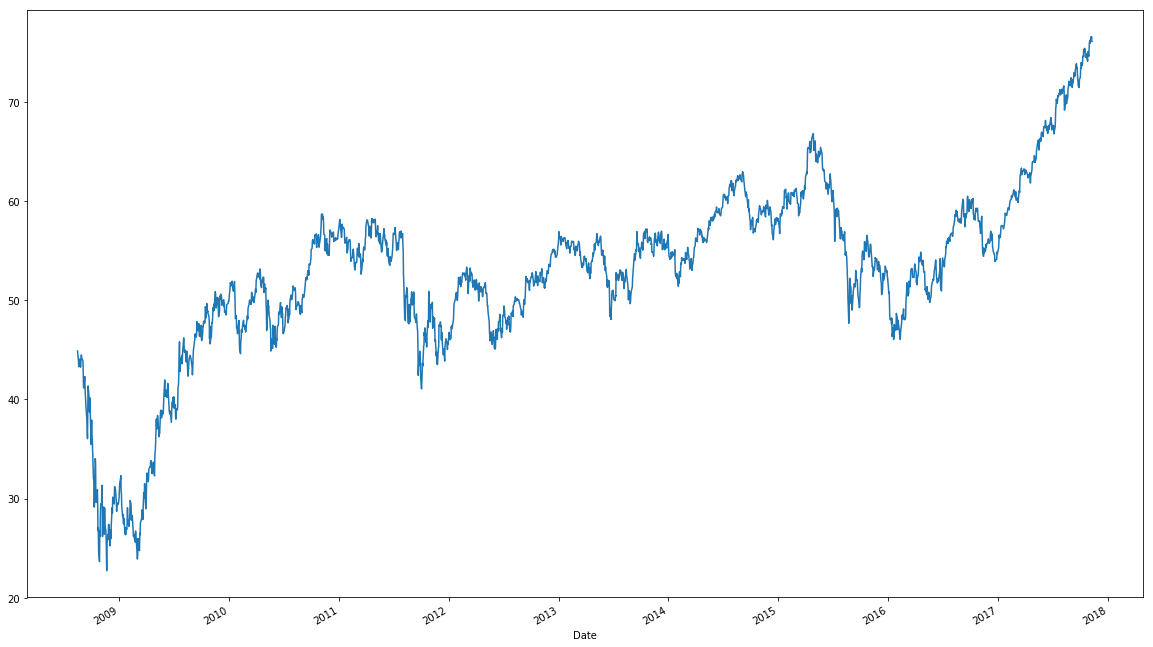

In [70]:
test['Close'].plot(figsize=(20,12))

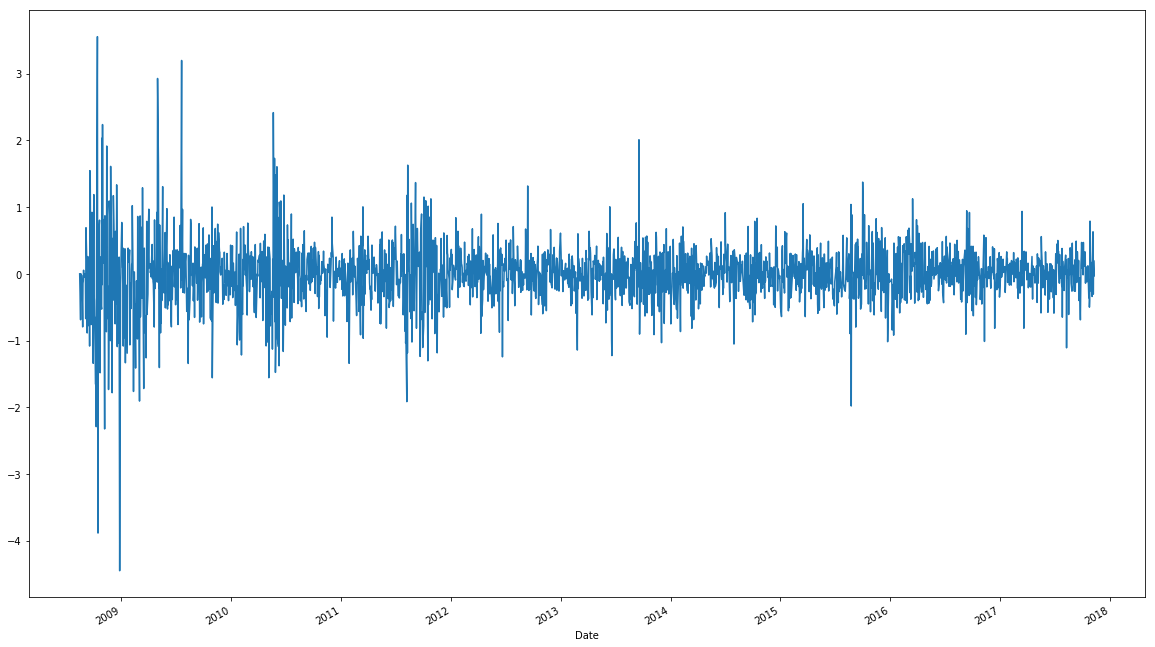

In [34]:
test['Change'].plot(figsize=(20,12))